In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Unzip the dataset file and store it in a folder called images.
# !unzip "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/images_segm/"

In [3]:
!pip install pycocotools
!pip install segmentation_models_pytorch

In [4]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import skimage.io as io
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import DataLoader, TensorDataset
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim

# Example: Using U-Net from segmentation_models_pytorch
import segmentation_models_pytorch as smp



In [5]:
# Path to annotation file
train_ann_path = '/content/drive/MyDrive/images_segm/train-300/labels.json'
train_img_dir = '/content/drive/MyDrive/images_segm/train-300/data/'


In [6]:
# Paths for validation data
val_ann_path = '/content/drive/MyDrive/images_segm/validation-300/labels.json'
val_img_dir = '/content/drive/MyDrive/images_segm/validation-300/data'

In [7]:
# Initialize COCO API
coco = COCO(train_ann_path)

# Define your classes
selected_classes = ['cake', 'car', 'dog', 'person']
cat_ids = coco.getCatIds(catNms=selected_classes)

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [8]:
# Extract and display COCO categories and supercategories for the training dataset.

category_IDs = coco.getCatIds()
categories = coco.loadCats(category_IDs)

print(categories)

[{'id': 0, 'name': 'airplane', 'supercategory': 'vehicle'}, {'id': 1, 'name': 'backpack', 'supercategory': 'accessory'}, {'id': 2, 'name': 'banana', 'supercategory': 'food'}, {'id': 3, 'name': 'baseball bat', 'supercategory': 'sports'}, {'id': 4, 'name': 'baseball glove', 'supercategory': 'sports'}, {'id': 5, 'name': 'bear', 'supercategory': 'animal'}, {'id': 6, 'name': 'bench', 'supercategory': 'outdoor'}, {'id': 7, 'name': 'bicycle', 'supercategory': 'vehicle'}, {'id': 8, 'name': 'bird', 'supercategory': 'animal'}, {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'}, {'id': 10, 'name': 'book', 'supercategory': 'indoor'}, {'id': 11, 'name': 'bottle', 'supercategory': 'kitchen'}, {'id': 12, 'name': 'bowl', 'supercategory': 'kitchen'}, {'id': 13, 'name': 'broccoli', 'supercategory': 'food'}, {'id': 14, 'name': 'bus', 'supercategory': 'vehicle'}, {'id': 15, 'name': 'cake', 'supercategory': 'food'}, {'id': 16, 'name': 'car', 'supercategory': 'vehicle'}, {'id': 17, 'name': 'carrot', 'sup

In [9]:
# Extract category names and supercategories
names_catg = [cat["name"] for cat in categories]
names_scatg = set(cat["supercategory"] for cat in categories)

print(f"{len(names_catg)} COCO categories: {', '.join(names_catg)}\n")
print(f"{len(names_scatg)} COCO supercategories: {', '.join(names_scatg)}")


63 COCO categories: airplane, backpack, banana, baseball bat, baseball glove, bear, bench, bicycle, bird, boat, book, bottle, bowl, broccoli, bus, cake, car, carrot, cat, cell phone, chair, clock, cow, cup, dining table, dog, donut, elephant, fire hydrant, fork, frisbee, giraffe, handbag, horse, hot dog, kite, knife, laptop, motorcycle, oven, parking meter, person, pizza, potted plant, refrigerator, remote, sandwich, scissors, skateboard, skis, spoon, sports ball, stop sign, suitcase, surfboard, tennis racket, tie, traffic light, train, truck, umbrella, vase, wine glass

12 COCO supercategories: kitchen, outdoor, furniture, appliance, vehicle, sports, accessory, person, indoor, food, animal, electronic


In [10]:
def get_catg_name(catg_id, categories):
    for cat in categories:
        if cat["id"] == catg_id:
            return cat["name"]
    return "None"


In [11]:
target_classes = ['cake', 'car', 'dog', 'person']
target_classes_IDs = coco.getCatIds(catNms=target_classes)
print("Target Category IDs:", target_classes_IDs)


Target Category IDs: [15, 16, 25, 41]


In [12]:
training_images = []

for class_name in target_classes:
    image_ids = coco.getImgIds(catIds=coco.getCatIds(catNms=[class_name]))
    print(f"{class_name}: {len(image_ids)} images")
    training_images += coco.loadImgs(image_ids)


cake: 1 images
car: 283 images
dog: 10 images
person: 272 images


In [13]:
# Remove duplicates
unique_training_images = list({img["id"]: img for img in training_images}.values())

# Shuffle for randomness
random.seed(0)
random.shuffle(unique_training_images)

print(f"Number of unique images: {len(unique_training_images)}")


Number of unique images: 300


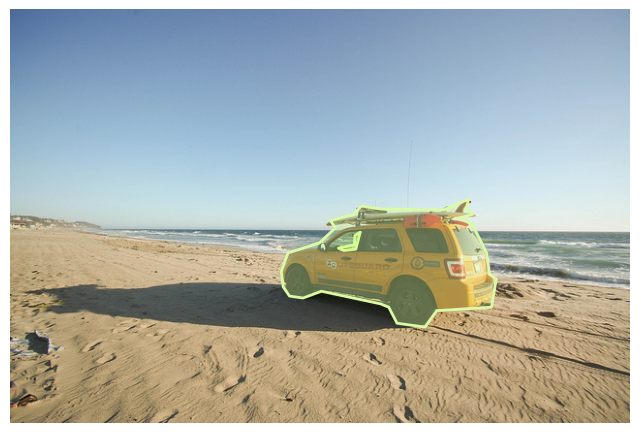

In [14]:
# Display example image and its annotations
example_image = unique_training_images[10]
img_id = example_image['id']
img_path = os.path.join(train_img_dir, example_image['file_name'])

image = io.imread(img_path)
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")

ann_ids = coco.getAnnIds(imgIds=img_id, catIds=target_classes_IDs, iscrowd=None)
annotations = coco.loadAnns(ann_ids)
coco.showAnns(annotations, draw_bbox=False)
plt.show()


Mask pixel values: [0 2 4]


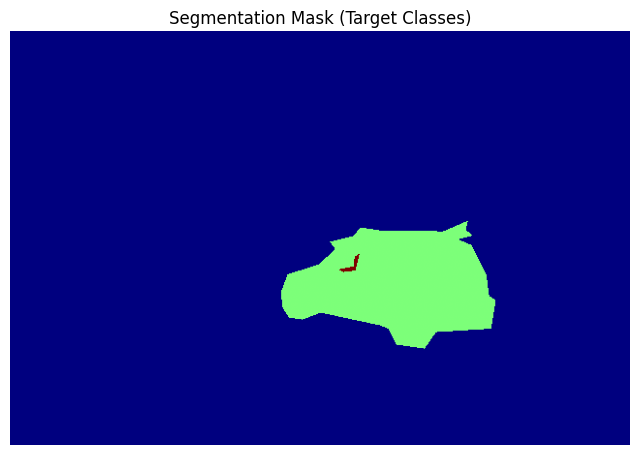

In [15]:
# Initialize empty mask
mask = np.zeros((example_image["height"], example_image["width"]), dtype=np.uint8)

# Assign pixel values to each class
for ann in annotations:
    class_name = get_catg_name(ann["category_id"], categories)
    if class_name in target_classes:
        pixel_val = target_classes.index(class_name) + 1
        mask = np.maximum(coco.annToMask(ann) * pixel_val, mask)

print("Mask pixel values:", np.unique(mask))

# Plot segmentation mask
plt.figure(figsize=(8, 6))
plt.imshow(mask, cmap='jet')
plt.axis("off")
plt.title("Segmentation Mask (Target Classes)")
plt.show()


In [16]:
# Get image IDs that contain at least one of the selected categories
img_ids = set()
for cat_id in cat_ids:
    img_ids.update(coco.getImgIds(catIds=cat_id))
img_ids = list(img_ids)

In [17]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
], additional_targets={'mask': 'mask'})


In [18]:
images = []
masks = []

for img_id in img_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(train_img_dir, img_info['file_name'])
    img = np.array(Image.open(img_path).convert("RGB"))

    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        cat_id = ann['category_id']
        class_idx = cat_ids.index(cat_id) + 1  # background is 0
        mask_obj = coco.annToMask(ann)
        mask[mask_obj == 1] = class_idx

    augmented = transform(image=img, mask=mask)
    images.append(augmented['image'])
    masks.append(augmented['mask'])


In [19]:
images_tensor = torch.stack(images)
masks_tensor = torch.stack(masks)

dataset = TensorDataset(images_tensor, masks_tensor)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [20]:
# Load COCO validation annotations
coco_val = COCO(val_ann_path)

# Use the same class names and get category IDs
selected_classes = ['cake', 'car', 'dog', 'person']
cat_ids_val = coco_val.getCatIds(catNms=selected_classes)


# Get image IDs that contain the selected classes
val_img_ids = set()
for cat_id in cat_ids_val:
    val_img_ids.update(coco_val.getImgIds(catIds=cat_id))
val_img_ids = list(val_img_ids)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [21]:
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

In [22]:
val_images = []
val_masks = []

for img_id in val_img_ids:
    img_info = coco_val.loadImgs(img_id)[0]
    img_path = os.path.join(val_img_dir, img_info['file_name'])
    img = np.array(Image.open(img_path).convert("RGB"))

    ann_ids = coco_val.getAnnIds(imgIds=img_id, catIds=cat_ids_val, iscrowd=False)
    anns = coco_val.loadAnns(ann_ids)

    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        cat_id = ann['category_id']
        class_idx = cat_ids_val.index(cat_id) + 1
        mask_obj = coco_val.annToMask(ann)
        mask[mask_obj == 1] = class_idx

    augmented = val_transform(image=img, mask=mask)
    val_images.append(augmented['image'])
    val_masks.append(augmented['mask'])


In [23]:
val_images_tensor = torch.stack(val_images)
val_masks_tensor = torch.stack(val_masks)

val_dataset = TensorDataset(val_images_tensor, val_masks_tensor)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [24]:
image_ids = list(set(img_ids))  # Remove duplicates
random.seed(42)
random.shuffle(image_ids)

val_img_ids =list(set(val_img_ids))
random.seed(42)
random.shuffle(val_img_ids)


In [25]:
print(f"Number of unique images in training data containing the target classes: {len(img_ids)}")
print(f"Number of unique images in validation data containing the target classes: {len(val_img_ids)}")

Number of unique images in training data containing the target classes: 300
Number of unique images in validation data containing the target classes: 300


In [26]:

# Define the model
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=5)  # 4 classes + background
model = model.cuda()  # Move model to GPU if available

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Best model tracker
best_val_loss = float('inf')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [27]:

def iou_score(pred_mask, true_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)

        intersection = (pred_cls & true_cls).sum()
        union = (pred_cls | true_cls).sum()

        if union == 0:
            ious.append(float('nan'))  # ignore this class in averaging
        else:
            ious.append(intersection / union)
    # Compute mean ignoring NaNs
    ious = np.array(ious)
    mean_iou = np.nanmean(ious)
    return mean_iou


In [28]:
num_classes = 5  # Set this to the number of classes you have (including background)
num_epochs=10
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    train_loss = 0

    for img, mask in train_loader:
        img, mask = img.cuda(), mask.cuda()
        mask = mask.long()

        output = model(img)
        loss = loss_fn(output, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_loss = 0
    ious_list = []

    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.cuda(), mask.cuda()
            mask = mask.long()

            output = model(img)
            loss = loss_fn(output, mask)
            val_loss += loss.item()

            # Convert output logits to predicted class indices
            preds = torch.argmax(output, dim=1)

            # Compute IoU for each image in batch
            for i in range(preds.shape[0]):
                pred_mask_np = preds[i].cpu().numpy()
                true_mask_np = mask[i].cpu().numpy()
                iou = iou_score(pred_mask_np, true_mask_np, num_classes)
                ious_list.append(iou)

    avg_val_loss = val_loss / len(val_loader)
    mean_iou = np.mean(ious_list)

    print(f"[Epoch {epoch+1}] Val Loss: {avg_val_loss:.4f}, Mean IoU: {mean_iou:.4f}")

    # --- Save best model ---
    if avg_val_loss < best_val_loss:
        print(f"✅ Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')


[Epoch 1] Train Loss: 1.2341
[Epoch 1] Val Loss: 0.8710, Mean IoU: 0.2116
✅ Validation loss improved from inf to 0.8710. Saving model...
[Epoch 2] Train Loss: 0.7171
[Epoch 2] Val Loss: 0.5468, Mean IoU: 0.3637
✅ Validation loss improved from 0.8710 to 0.5468. Saving model...
[Epoch 3] Train Loss: 0.5077
[Epoch 3] Val Loss: 0.4500, Mean IoU: 0.4214
✅ Validation loss improved from 0.5468 to 0.4500. Saving model...
[Epoch 4] Train Loss: 0.3872
[Epoch 4] Val Loss: 0.3764, Mean IoU: 0.4350
✅ Validation loss improved from 0.4500 to 0.3764. Saving model...
[Epoch 5] Train Loss: 0.3125
[Epoch 5] Val Loss: 0.3387, Mean IoU: 0.4545
✅ Validation loss improved from 0.3764 to 0.3387. Saving model...
[Epoch 6] Train Loss: 0.2711
[Epoch 6] Val Loss: 0.3106, Mean IoU: 0.4519
✅ Validation loss improved from 0.3387 to 0.3106. Saving model...
[Epoch 7] Train Loss: 0.2540
[Epoch 7] Val Loss: 0.3002, Mean IoU: 0.4619
✅ Validation loss improved from 0.3106 to 0.3002. Saving model...
[Epoch 8] Train Loss: 0

In [29]:
# Load best model weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
model.cuda()


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [30]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])


In [31]:
model.eval()  # Ensure model is in eval mode
all_preds = []
all_masks = []
all_images = []

with torch.no_grad():
    for img_batch, mask_batch in val_loader:
        img_batch = img_batch.cuda()
        output = model(img_batch)  # Output shape: (B, C, H, W)
        preds = torch.argmax(output, dim=1).cpu()  # Shape: (B, H, W)
        all_preds.extend(preds)
        all_masks.extend(mask_batch)
        all_images.extend(img_batch.cpu())


In [32]:
# Map for: 0=background, 1=cake, 2=car, 3=dog, 4=person
colors = {
    0: (0, 0, 0),
    1: (255, 105, 180),  # cake - pink
    2: (30, 144, 255),   # car - blue
    3: (34, 139, 34),    # dog - green
    4: (255, 215, 0)     # person - gold
}

def decode_mask(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in colors.items():
        color_mask[mask == class_idx] = color
    return color_mask


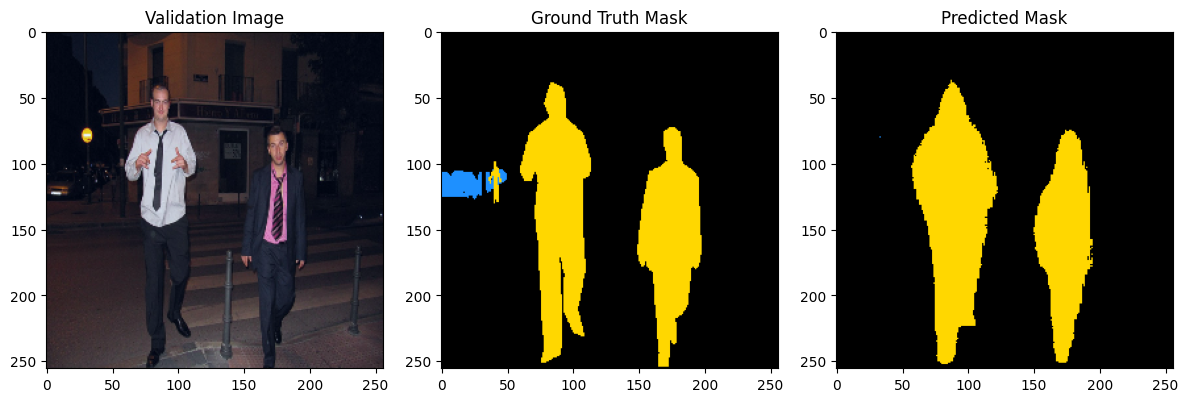

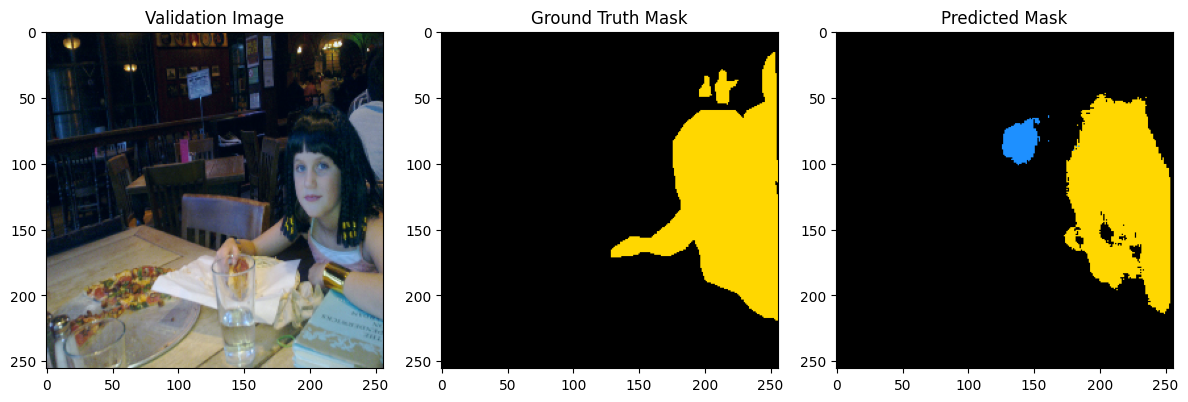

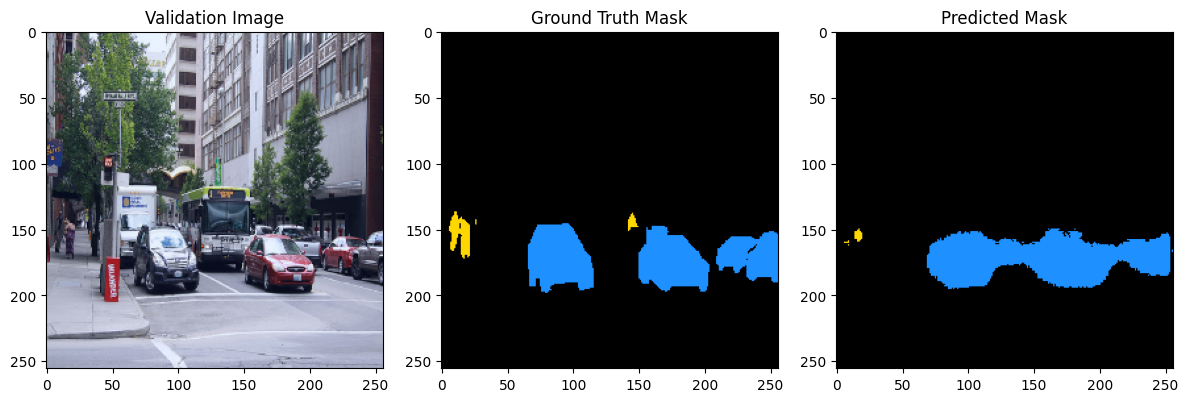

In [33]:
import matplotlib.pyplot as plt

# Show the first 5 validation predictions
for i in range(26,29):
    image = all_images[i].permute(1, 2, 0).numpy()  # Convert from tensor
    image = (image - image.min()) / (image.max() - image.min())  # Normalize for display

    true_mask = all_masks[i].numpy()
    pred_mask = all_preds[i].numpy()

    true_color = decode_mask(true_mask)
    pred_color = decode_mask(pred_mask)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Validation Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_color)
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_color)
    plt.title("Predicted Mask")

    plt.tight_layout()
    plt.show()


In [34]:
correct = 0
total = 0
for pred, true in zip(all_preds, all_masks):
    correct += (pred == true).sum().item()
    total += (pred.numel())

accuracy = correct / total
print(f"Validation Pixel Accuracy: {accuracy:.4f}")


Validation Pixel Accuracy: 0.9195


In [35]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

test_dir = '/content/drive/MyDrive/images_segm/test-30'
test_filenames = sorted(os.listdir(test_dir))  # Ensure consistent order

test_images = []
original_images = []

for fname in test_filenames:
    img_path = os.path.join(test_dir, fname)
    image = np.array(Image.open(img_path).convert("RGB"))

    original_images.append(image.copy())  # Save for visualization

    transformed = test_transform(image=image)
    test_images.append(transformed['image'])


In [36]:
test_batch = torch.stack(test_images).cuda()  # Batch all test images
with torch.no_grad():
    preds = model(test_batch)  # Shape: (B, C, H, W)
    preds = torch.argmax(preds, dim=1).cpu().numpy()  # Shape: (B, H, W)


In [37]:
# Define colors for each class: background, cake, car, dog, person
colors = {
    0: (0, 0, 0),        # background - black
    1: (255, 105, 180),  # cake - pink
    2: (30, 144, 255),   # car - blue
    3: (34, 139, 34),    # dog - green
    4: (255, 215, 0)     # person - gold
}

def decode_segmentation_mask(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in colors.items():
        color_mask[mask == class_idx] = color
    return color_mask


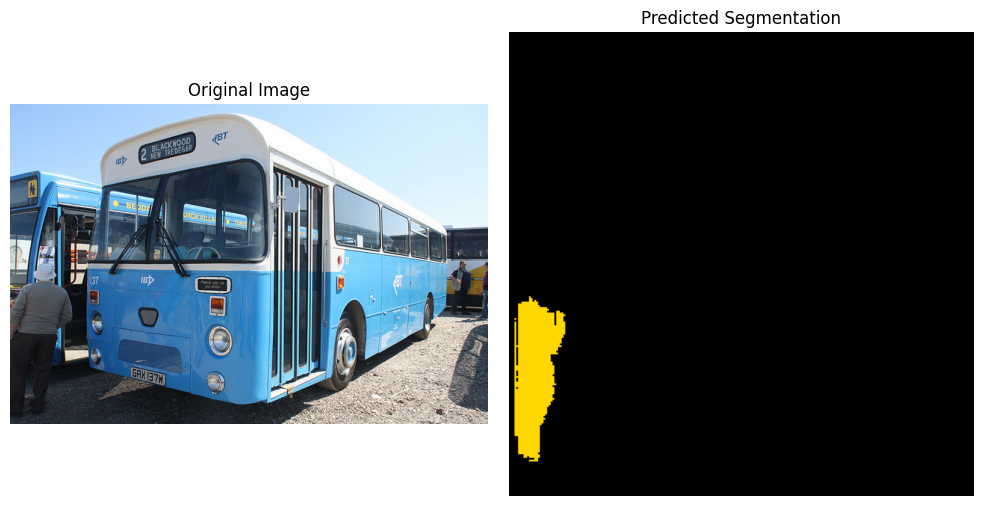

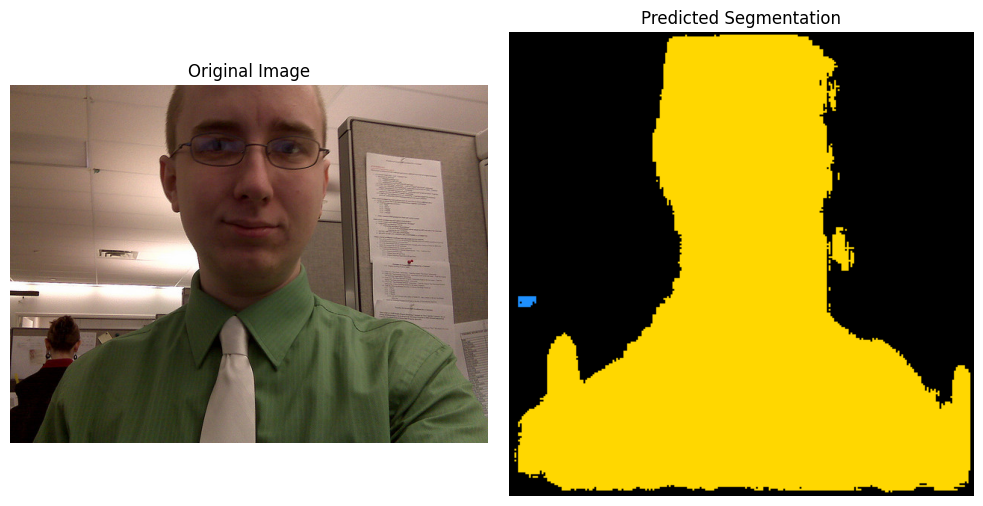

In [38]:
# Visualize 2 test predictions
for i in range(4,6):
    original = original_images[i]
    prediction_mask = decode_segmentation_mask(preds[i])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(original)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask)
    plt.title("Predicted Segmentation")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
